In [ ]:
#1. Environment Setup and Dependencies

# %%
# Install required packages
!pip install -q transformers datasets accelerate scikit-learn pandas numpy torch


import os
import warnings
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
)
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f'Using device: {device}')

In [ ]:
# ## 2. Configuration

class Config:
    """Configuration class for model training"""
    # Model
    MODEL_NAME = 'xlm-roberta-base'
    MAX_LENGTH = 128
    NUM_LABELS = 3  # FIXED: Changed from 2 to 3 for your dataset

    # Training
    BATCH_SIZE = 16  # Reduced from 32 to avoid memory issues
    LEARNING_RATE = 2e-5
    EPOCHS = 3
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01

    # Data
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    # Paths
    TRAIN_DATA_PATH = '/content/trainDataset.csv'
    TEST_DATA_PATH = '/content/testDataset.csv'
    MODEL_SAVE_PATH = './sms_classifier_model'

config = Config()

In [ ]:
# ## 3. Data Loading and Preprocessing

def load_data(file_path: str) -> pd.DataFrame:
    """
    Load SMS dataset with flexible column handling
    """
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        logger.info(f"Original columns: {df.columns.tolist()}")

        # Handle different column name possibilities
        text_col = None
        label_col = None

        # Look for text column
        for col in df.columns:
            if col.lower() in ['text', 'message', 'sms', 'content']:
                text_col = col
                break

        # Look for label column
        for col in df.columns:
            if col.lower() in ['label', 'class', 'category', 'type']:
                label_col = col
                break

        if text_col is None or label_col is None:
            # Fall back to first two columns
            text_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]
            label_col = df.columns[0]

        # Rename columns to standard names
        df = df[[label_col, text_col]].rename(columns={label_col: 'label', text_col: 'text'})

        # Handle string labels - create mapping dynamically
        if df['label'].dtype == 'object':
            unique_labels = sorted(df['label'].unique())
            label_map = {label: idx for idx, label in enumerate(unique_labels)}
            df['label'] = df['label'].map(label_map)
            logger.info(f"Label mapping: {label_map}")

            # Save label mapping for later use
            config.LABEL_MAP = label_map
            config.REVERSE_LABEL_MAP = {v: k for k, v in label_map.items()}

        # Remove nulls and empty strings
        df = df.dropna()
        df = df[df['text'].str.strip() != '']

        logger.info(f"Loaded {len(df)} samples")
        logger.info(f"Class distribution:\n{df['label'].value_counts()}")

        return df

    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

# Load datasets - TRAINING DATA FIRST
train_df = load_data(config.TRAIN_DATA_PATH)
test_df = load_data(config.TEST_DATA_PATH)

# Use training data for train/val split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'].values,
    train_df['label'].values,
    test_size=0.1,  # 10% for validation
    random_state=config.RANDOM_STATE,
    stratify=train_df['label']
)

# Test data is separate
X_test = test_df['text'].values
y_test = test_df['label'].values



In [ ]:
# 4. Dataset Class

class SMSDataset(Dataset):
    """PyTorch Dataset for SMS Classification"""

    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# ## 5. Model Initialization
tokenizer = XLMRobertaTokenizer.from_pretrained(config.MODEL_NAME)
model = XLMRobertaForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS
)

model = model.to(device)
logger.info(f"Model loaded: {config.MODEL_NAME}")


# Create datasets and dataloaders
train_dataset = SMSDataset(X_train, y_train, tokenizer, config.MAX_LENGTH)
val_dataset = SMSDataset(X_val, y_val, tokenizer, config.MAX_LENGTH)  # Add this line
test_dataset = SMSDataset(X_test, y_test, tokenizer, config.MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)  # Add this line
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 6. Training Setup
# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

total_steps = len(train_loader) * config.EPOCHS
warmup_steps = int(total_steps * config.WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [ ]:
# 7.Training Functions

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

    return total_loss / len(data_loader), accuracy_score(actual_labels, predictions)

def evaluate(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    # FIXED: Changed from 'binary' to 'weighted' for multi-class
    precision, recall, f1, _ = precision_recall_fscore_support(
        actual_labels, predictions, average='weighted'
    )

    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'labels': actual_labels
    }

In [ ]:
# ## 8. Training Loop

# Training
best_val_f1 = 0
training_history = []

for epoch in range(config.EPOCHS):
    logger.info(f"\nEpoch {epoch + 1}/{config.EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validate
    val_metrics = evaluate(model, val_loader, device)
    logger.info(
        f"Val Loss: {val_metrics['loss']:.4f}, "
        f"Val Acc: {val_metrics['accuracy']:.4f}, "
        f"Val F1: {val_metrics['f1']:.4f}"
    )

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        torch.save(model.state_dict(), f"{config.MODEL_SAVE_PATH}_best.pt")
        logger.info("Saved best model")

    training_history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_metrics['loss'],
        'val_acc': val_metrics['accuracy'],
        'val_f1': val_metrics['f1']
    })


TEST SET RESULTS
Accuracy: 0.9892
Precision: 0.9892
Recall: 0.9892
F1 Score: 0.9892

Detailed Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.99      0.99       197
       promo       0.99      0.98      0.99       191
       smish       0.99      0.99      0.99       167

    accuracy                           0.99       555
   macro avg       0.99      0.99      0.99       555
weighted avg       0.99      0.99      0.99       555


Confusion Matrix:
[[196   0   1]
 [  2 188   1]
 [  1   1 165]]


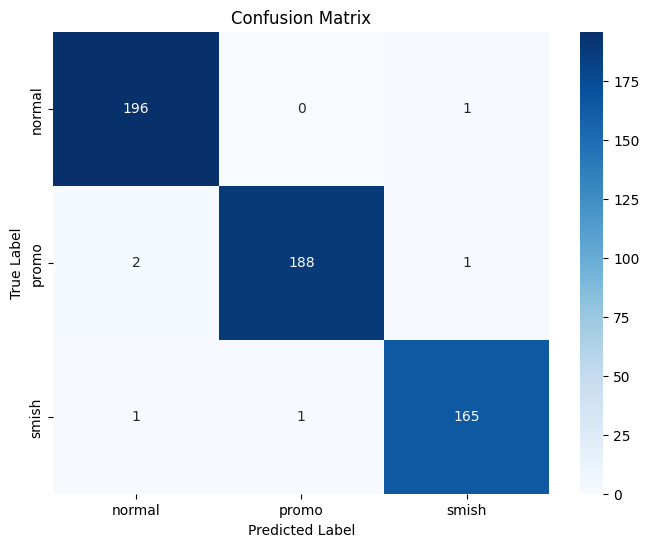

In [ ]:
# ## 9. Evaluation on Test Set

model.load_state_dict(torch.load(f"{config.MODEL_SAVE_PATH}_best.pt"))

# Test evaluation
test_metrics = evaluate(model, test_loader, device)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

# Detailed classification report
if hasattr(config, 'REVERSE_LABEL_MAP'):
    class_names = [config.REVERSE_LABEL_MAP[i] for i in range(config.NUM_LABELS)]
    print(f"\nDetailed Classification Report:")
    print(classification_report(test_metrics['labels'], test_metrics['predictions'],
                              target_names=class_names))

# Confusion matrix
cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])
print(f"\nConfusion Matrix:\n{cm}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
if hasattr(config, 'REVERSE_LABEL_MAP'):
    class_names = [config.REVERSE_LABEL_MAP[i] for i in range(config.NUM_LABELS)]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# ## 10. Save Model for Production

model.save_pretrained(config.MODEL_SAVE_PATH)
tokenizer.save_pretrained(config.MODEL_SAVE_PATH)

# Save config
import json
config_dict = {k: v for k, v in vars(config).items() if not k.startswith('_')}
with open(f"{config.MODEL_SAVE_PATH}/training_config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

logger.info(f"Model saved to {config.MODEL_SAVE_PATH}")

In [ ]:
# ## 11. Inference Pipeline

class SMSClassifier:
    """Production-ready SMS classification pipeline"""

    def __init__(self, model_path: str):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
        self.model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

        # Load label mapping if available
        try:
            with open(f"{model_path}/training_config.json", 'r') as f:
                config_dict = json.load(f)
                if 'REVERSE_LABEL_MAP' in config_dict:
                    self.label_map = config_dict['REVERSE_LABEL_MAP']
                    # Convert string keys back to integers
                    self.label_map = {int(k): v for k, v in self.label_map.items()}
                else:
                    self.label_map = {0: 'Class_0', 1: 'Class_1', 2: 'Class_2'}
        except:
            self.label_map = {0: 'Class_0', 1: 'Class_1', 2: 'Class_2'}

    def predict(self, text: str) -> Dict:
        """Predict class for a single text"""
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(outputs.logits, dim=1)

        pred_label = self.label_map.get(prediction.item(), f'Class_{prediction.item()}')

        result = {
            'text': text,
            'prediction': pred_label,
            'confidence': probs[0][prediction.item()].item()
        }

        # Add probabilities for each class
        for i, prob in enumerate(probs[0]):
            class_name = self.label_map.get(i, f'Class_{i}')
            result[f'{class_name}_probability'] = prob.item()

        return result

    def predict_batch(self, texts: List[str]) -> List[Dict]:
        """Predict classes for multiple texts"""
        return [self.predict(text) for text in texts]

# Initialize classifier
classifier = SMSClassifier(config.MODEL_SAVE_PATH)

In [ ]:
# ## 12. Test Inference

test_messages = [
    "আপনার বন্ধুদের রেফার করুন এবং প্রতি রেফারেলে ২০০ টাকা জিতুন!",
    "কোড: upay15 ক্লিক করুনঃ onelink.to/j7rwyf",
    "আপু আমার মেয়ে আজকে শরীর খারাপ... আমি কালকে যাবো",
    "নতুন ল্যাপটপ লঞ্চ! আজই কিনুন এবং পান ২০% ছাড়। বিস্তারিত জানতে এই লিঙ্কে ক্লিক করুন"
]

print("\nSample Predictions:")
print("="*80)

for msg in test_messages:
    result = classifier.predict(msg)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")


Sample Predictions:

Text: আপনার বন্ধুদের রেফার করুন এবং প্রতি রেফারেলে ২০০ টাকা জিতুন!
Prediction: smish
Confidence: 99.86%

Text: কোড: upay15 ক্লিক করুনঃ onelink.to/j7rwyf
Prediction: smish
Confidence: 99.79%

Text: আপু আমার মেয়ে আজকে শরীর খারাপ... আমি কালকে যাবো
Prediction: normal
Confidence: 99.89%

Text: নতুন ল্যাপটপ লঞ্চ! আজই কিনুন এবং পান ২০% ছাড়। বিস্তারিত জানতে এই লিঙ্কে ক্লিক করুন
Prediction: promo
Confidence: 95.61%


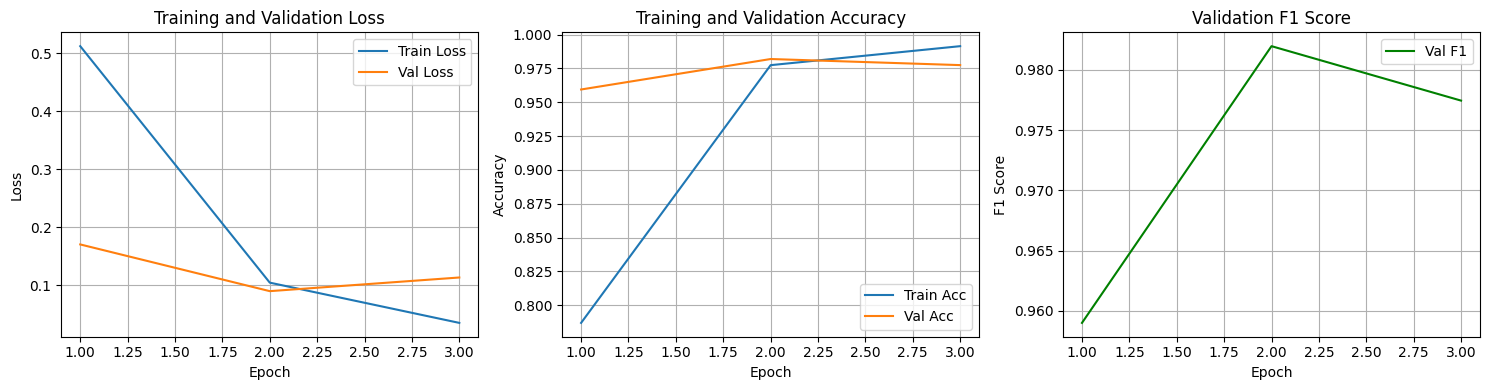


Final Model Performance:
Best Validation F1: 0.9820
Test Set F1: 0.9892


In [ ]:
# ## 13. Model Performance Summary

# %%
# Display training history
import matplotlib.pyplot as plt

history_df = pd.DataFrame(training_history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
axes[1].plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# F1 Score plot
axes[2].plot(history_df['epoch'], history_df['val_f1'], label='Val F1', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Validation F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Model Performance:")
print(f"Best Validation F1: {best_val_f1:.4f}")
print(f"Test Set F1: {test_metrics['f1']:.4f}")